In [1]:
import numpy as np
from scipy.integrate import quad, dblquad
import sympy as sym
import scipy.special as sps
import scipy.stats as spss
from astropy import constants as const
from astropy import units
import matplotlib.pyplot as plt
import scipy.optimize as spopt

In [9]:
# circular orbits
sym.integrate((-Epr)**((6-gam)/(2*(4-gam))) * (Epr+1/r)**0.5, (Epr, -1/r, 0))
# Solved

0.666666666666667*r**(-1.5)*r**(gamma/(2*(4 - gamma)))*r**(-3/(4 - gamma))*hyper((1.5, gamma/(2*(4 - gamma)) - 3/(4 - gamma)), (2.5,), 1)

In [2]:
# functions and parameters
c = const.c
G = const.G
M1 = 2.6e6* units.solMass
Rs1 = (2*G*M1/c**2).to(units.parsec).value
r = np.logspace(np.log10(4.01*Rs1), 4, 100)

def pars(r, gamma, r_0, rho_0, M=M1, Rs=Rs1):
    
    r_0 = r_0 *units.parsec
    rho_0 = rho_0 *units.solMass/units.parsec**3
    
    # parameters
    lamda = (2/(4-gamma))**(1/(2-gamma)) * ((2-gamma)/(4-gamma))**(1/2)
    b = np.pi*(2-gamma) /sps.beta(1/(2-gamma), 3/2)
    beta = (6-gamma)/(2*(2-gamma))
    k = (3-gamma)/(gamma-4)
    kappa = (b*lamda-1)/(b*lamda)
    gamma_sp = (9-2*gamma)/(4-gamma)
    
    phi = 4*np.pi*G*r_0**2*rho_0/((3-gamma)*(2-gamma))
    
#     A1 = (b*phi**(1/(2-gamma)) / (2*r_0**2)**0.5) ** (-(6-gamma)/(4-gamma))
#     A2 = rho_0/(2*np.pi*phi)**(3/2) * sps.gamma(beta)/sps.gamma(beta-3/2) * phi**beta
    A1 = (phi * (b/(2*r_0**2*phi)**0.5)**(2*(2-gamma)/(4-gamma))) ** (-beta)
    A2 = rho_0/(2*np.pi*phi)**(3/2) * sps.gamma(beta)/sps.gamma(beta-3/2) * phi**beta
    Anew = 4*np.pi * A1*A2 * (G*M)**((3-gamma)/(4-gamma))

#     A = (M**(3-gamma) * rho_0 * r_0**gamma)**(1/(4-gamma))
#     B = 4*np.pi*1/((2*np.pi)**(3/2)) * (b/np.sqrt(2))**(-(6-gamma)/(4-gamma)) * sps.gamma(beta)/sps.gamma(beta-3/2) * (4*np.pi/((3-gamma)*(2-gamma)))**k
#     Anew = A*B
    return Anew, gamma_sp
    
def g(r, gamma, M=M1, Rs=Rs1):
    lamda = (2/(4-gamma))**(1/(2-gamma)) * ((2-gamma)/(4-gamma))**(1/2)
    b = np.pi*(2-gamma) /sps.beta(1/(2-gamma), 3/2)
    kappa = (b*lamda-1)/(b*lamda)

    # numerical integration
    integ_arr = []
    err = []
    func = lambda y, x: y * (-kappa*y + 1/((-2*x)**(1/2)) )**((gamma-6)/(4-gamma)) / (2*(x + 1 - (y**2)/2))**(1/2)
    for ri in r:
        num_integ = dblquad(func, -(1-4*Rs/ri), 0, 2*(2*Rs/ri)**0.5, lambda x: (2 * (x+1))**0.5 )
        integ_arr.append(num_integ[0])
        err.append(num_integ[1])          
        
    return integ_arr, err

def rho_prime(a, integ, r, gam_sp):
    return (a*integ*(r*units.parsec)**(-gam_sp)).value

t_bh = 1e10 *units.year # age of the BH
sigmav = 3e-26 *units.cm**3/units.s # WIMP annihilation cross-section
m = (100 *units.GeV/c**2).to(units.solMass) # DM particle mass
rho_core = (m/(sigmav*t_bh)).to(units.solMass/units.parsec**3).value

def rho_sp(rho_pr, rho_core=rho_core):
    return rho_pr*rho_core/(rho_pr+rho_core)

def rho0(r_0, gamma):
    return (1-gamma/3)*0.0062*(8500/r_0)**gamma

def r_cut(r, rho_sp, rho_core=rho_core): # radius where rho_sp = rho_core
    return r[rho_sp==rho_sp[(rho_sp>0.7*rho_core) & (rho_sp<1.5*rho_core) & (r>1e-5)]]

In [3]:
integ1, err1 = g(r, 0.01)
integ2, err2 = g(r, 0.1)
integ3, err3 = g(r, 1)
integ4, err4 = g(r, 1.6)

In [7]:
D = 8500 # Sun distance from centre
a1, gam_sp1 = pars(r, 0.01, D, rho0(D, 0.01))
a2, gam_sp2 = pars(r, 0.1, D, rho0(D, 0.1))
a3, gam_sp3 = pars(r, 1, D, rho0(D, 1))
a4, gam_sp4 = pars(r, 1.6, D, rho0(D, 1.6))

anew, gam_spnew = pars(r, 1, 3000, 1e10/(np.pi*3000**3)) # to compare with Hernquist

[1.38778525 1.9996583 ]


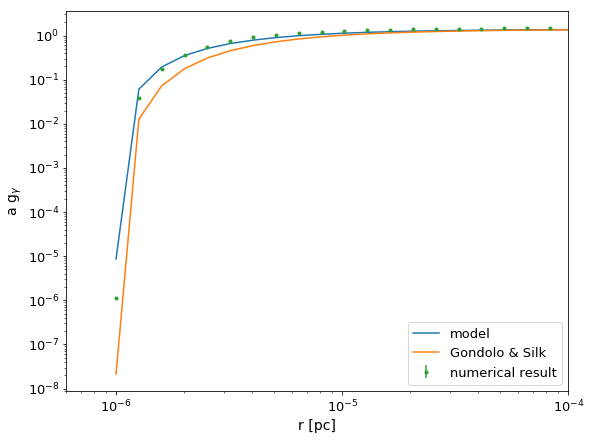

In [8]:
def model(x, *par, Rs_m=Rs1):
    return par[0]*(1-4*Rs_m/x)**par[1]

xval = r
yval = integ4
params, cov = spopt.curve_fit(model, xval, yval, p0=[1, 3], sigma=err1)
print(params)
yerr =(err1)
yy=(integ1)

plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(9,7))
plt.plot(r, model(r,*params), label='model')
plt.plot(r, params[0]*(1-4*Rs1/r)**3, label='Gondolo & Silk')
#plt.plot(r, a1*b1*integ1*r**(-gam_sp1))
plt.errorbar(r, yy, yerr=yerr, fmt=".", label='numerical result')
# plt.plot(r, a1*params[0]*r**(-gam_sp1), label='without g(r)')
plt.legend()
plt.xlabel('r [pc]', fontsize=14)
plt.ylabel('a g$_γ$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(6e-7,1e-4)
plt.show()

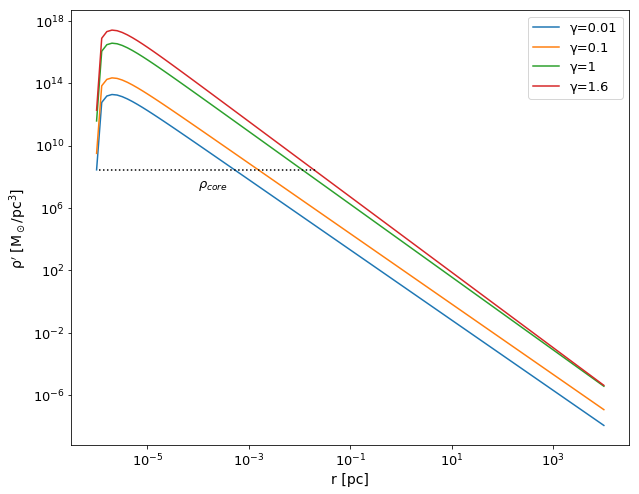

In [9]:
rho_sp1 = (rho_prime(a1,integ1,r,gam_sp1))
rho_sp2 = (rho_prime(a2,integ2,r,gam_sp2))
rho_sp3 = (rho_prime(anew,integ3,r,gam_spnew))
rho_sp4 = (rho_prime(a4,integ4,r,gam_sp4))

plt.figure(figsize=(10,8))
plt.plot(r, rho_sp1, label='γ=0.01')
plt.plot(r, rho_sp2, label='γ=0.1')
plt.plot(r, rho_sp3, label='γ=1')
plt.plot(r, rho_sp4, label='γ=1.6')
plt.axhline(rho_core, 0.05, 0.44, linestyle=':', color='black')
plt.text(1e-4,2e7, '$ρ_{core}$')

plt.legend()
plt.xlabel('r [pc]', fontsize=14)
plt.ylabel('ρ$^\prime$ [M$_\odot$/pc$^3$]', fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [12]:
np.savetxt('rho_sp001', rho_sp1)
np.savetxt('rho_sp01', rho_sp2)
np.savetxt('rho_sp1 compare', rho_sp3)
np.savetxt('rho_sp16', rho_sp4)

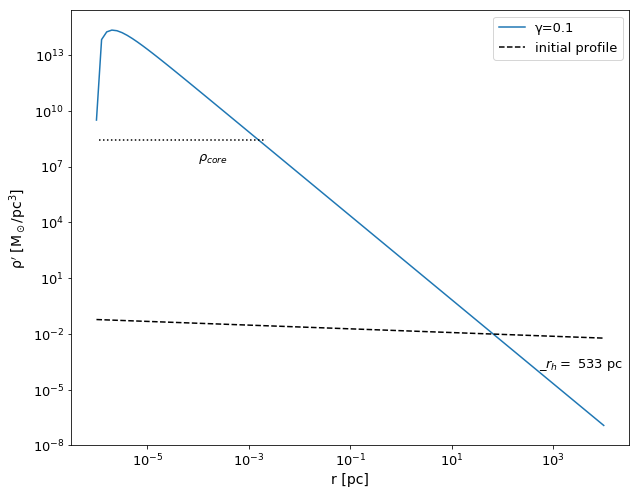

In [8]:
def r_h(gamma, M_bh, rho_0, r_0):
    return r_0* ((3-gamma)/(2*np.pi) * M_bh/(rho_0*r_0**3)) ** (1/(3-gamma))

r_h2 = r_h(0.1, M1, rho0(0.1,0.1), 0.1)
plt.figure(figsize=(10,8))

plt.plot(r, rho_sp2, label='γ=0.1')
plt.axhline(rho_core, 0.05, 0.35, linestyle=':', color='black')
plt.text(1e-4,2e7, '$ρ_{core}$')
rho_i = rho0(0.1, 0.1)*(0.1/r)**0.1
plt.plot(r, rho_i, color='black', linestyle='--', label='initial profile')
plt.text(r_h2.value, 1.6e-4, '_$r_h=$ %.f pc' %r_h2.value, fontsize='13')

plt.legend()
plt.xlabel('r [pc]', fontsize=14)
plt.ylabel('ρ$^\prime$ [M$_\odot$/pc$^3$]', fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.show()

Text(0, 0.5, 'r$_h$ [pc]')

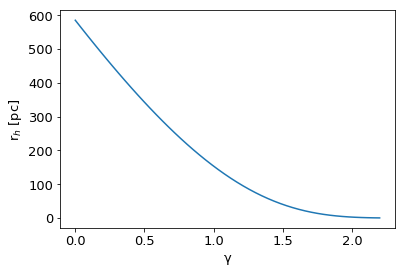

In [11]:
# r_h vs γ
M = M1.value
gam_arr = np.linspace(0,2.2, 50)
r_h_arr = r_h(gam_arr, M, rho0(0.1,gam_arr), 0.1)

plt.plot(gam_arr, r_h_arr)
plt.xlabel('γ')
plt.ylabel('r$_h$ [pc]')

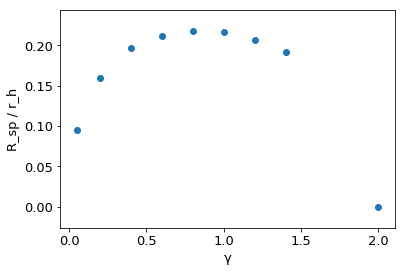

In [41]:
# r_h vs R_sp
R_sp = np.zeros(9)
gam_arr2 = np.array([0.05, 0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4, 2])
a_g = np.array([0.0733, 0.12, 0.14, 0.142, 0.135, 0.122, 0.103, 0.0818, 0.0177])
R_sp[:-1] = a_g[:-1]*0.1*(M/(rho0(0.1,gam_arr2)[:-1]*0.1**3))**(1/(3-gam_arr2[:-1]))
r_h_arr2 = r_h(gam_arr2, M, rho0(0.1,gam_arr2), 0.1)

plt.scatter(gam_arr2, R_sp/r_h_arr2)
plt.xlabel('γ')
plt.ylabel('R_sp / r_h')
plt.show()

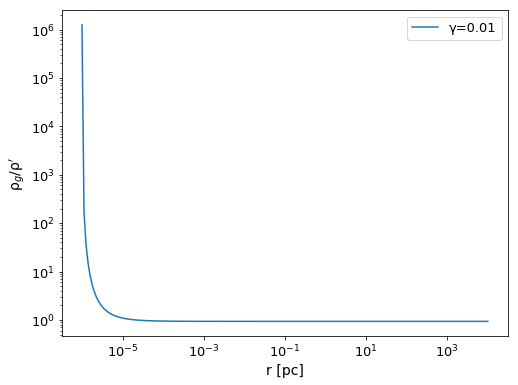

In [18]:
rho_g = (rho_prime(a1,params[0],r,gam_sp1))
plt.figure(figsize=(8,6))
# plt.plot(r, rho_sp1, label='γ=0.01')
plt.plot(r, rho_g/rho_sp1, label='γ=0.01')
plt.legend()
plt.xlabel('r [pc]', fontsize=14)
plt.ylabel('ρ$_g$/ρ$^{\prime}$', fontsize=14)
plt.xscale('log')
plt.yscale('log')

[1.38851144 2.00933211]


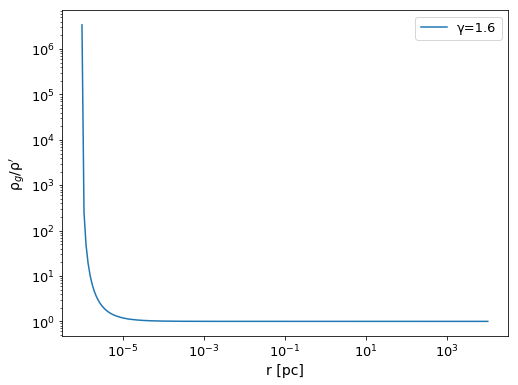

In [19]:
params2, cov = spopt.curve_fit(model, r, integ4, p0=[1, 3])
print(params2)

rho_g = (rho_prime(a4,params2[0],r,gam_sp4))
plt.figure(figsize=(8,6))
# plt.plot(r, rho_sp4, label='γ=1.6')
plt.plot(r, rho_g/rho_sp4, label='γ=1.6')
plt.legend()
plt.xlabel('r [pc]', fontsize=14)
plt.ylabel('ρ$_g$/ρ$^{\prime}$', fontsize=14)
plt.xscale('log')
plt.yscale('log')

In [79]:
# Comparing with Gondolo and Silk
gam_1 = 0.2
integ_c, err_c = g(r, gam_1)
integ_c2, err_c2 = g(r, 1.4)

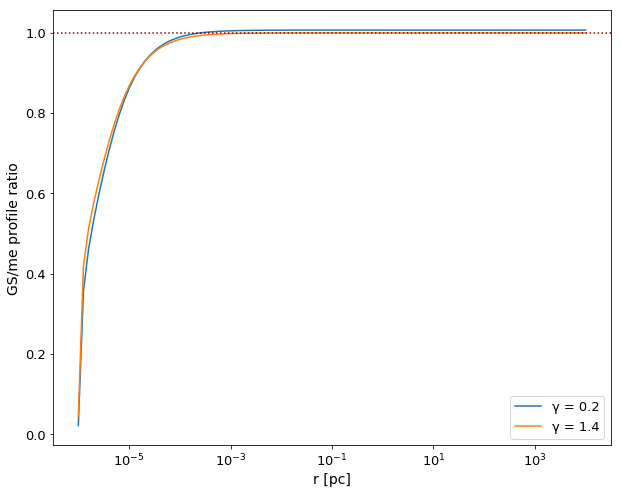

In [86]:
a_c, gam_spc = pars(r, gam_1, 0.1, 1e9)
a_c2, gam_spc2 = pars(r, 1.4, 0.1, 1e9)

# spike parameters
r_0 = 0.1 *units.parsec
rho_0 = 1e9 *units.solMass/units.parsec**3

def spike_profile(gam_1, a, r_0=r_0, rho_0=rho_0, r=r):
    gam_sp = (9-2*gam_1)/(4-gam_1)
    R_sp = a*r_0*(M1/(rho_0*r_0**3))**(1/(3-gam_1))
    rho_R = rho_0*(R_sp/r_0)**(-gam_1)
    g_r = (1-4*Rs1/r)**3
    
    return g_r*rho_R*(R_sp/r)**gam_sp, R_sp, rho_R

# gamma ray flux
def flux(gam, a, rho_sp, sigmav=sigmav.to(units.pc**3/units.s), m=m):
    gam_sp = (9-2*gam_1)/(4-gam_1)
    R_sp = spike_profile(gam, a)[1]
    rho_R = spike_profile(gam, a)[2]
    D = 1e3
    return rho_R**2 / (4*gam_sp-6) * sigmav/m**2 * R_sp**3/D**2 * (r_cut(r, rho_sp)/R_sp)**(-2*gam_sp+3)

gond1 = spike_profile(0.2, 0.12)[0]
gond2 = spike_profile(1.4, 0.0818)[0]

rho_me = rho_prime(a_c,integ_c,r,gam_spc)
rho_me2 = rho_prime(a_c2,integ_c2,r,gam_spc2)

plt.figure(figsize=(10,8))
# plt.plot(r, rho_prime(a_c,b_c,integ_c,r,gam_spc), label='me')
plt.plot(r, gond1/rho_me, label='γ = 0.2')
plt.plot(r, gond2/rho_me2, label='γ = 1.4')

# plt.plot(r, rho_prime(a_c,b_c,integ_c,r,gam_spc), label='me')
# plt.plot(r, 1e9*(r/0.1)**(-0.05), label='ρ')
plt.xlabel('r [pc]', fontsize=14)
plt.ylabel('GS/me profile ratio', fontsize=14)
# plt.text(R_sp.value, 2e9, '_R$_{sp}$', fontsize=12)
plt.axhline(1., linestyle=':', color='darkred')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

In [33]:
xval = r
yval = integ_c
params, cov = spopt.curve_fit(model, xval, yval, p0=[1, 3], sigma=err_c)
params

array([1.41254451, 1.9683395 ])

In [87]:
flux(0.1,0.07, rho_sp1)

<Quantity [5.15030354e+36] pc(3/2) / s>

In [26]:
gamma = 1.6
beta = (6-gamma)/(2*(2-gamma))
print(sps.gamma((2*gamma-2)/(gamma-2))/sps.gamma((2+gamma)/(2*(gamma-2))))
sps.gamma(beta)/sps.gamma(beta-3/2)

-2084318904799679.0


8.723796297425594